## 1- Import the required libraries

In [124]:
import pandas  as pd
import numpy as np
import pandas as pd
#from easypreprocessing import EasyPreProcessing
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import numpy as np
import datetime
import pandas as pd
import sklearn as sk
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error
from numpy import sqrt

## 2- Load the data

In [125]:
data = pd.read_csv('/Users/alijanehsan/Downloads/Final_project/merge.csv', index_col =0)

In [126]:
data.head()


,date,item_code,quantity,unit_price_vat_excl,unit_cogs,unit_rrp_vat_excl,department,site,Revenue,country,...,gender,age,color,size,kids,men,unisex,women,day,month
0,2022-01-14,ZB00245086,1,107.443868,63.815891,126.367186,E-COMMER,top4running.at,107.443868,Austria,...,men,adults,White,44,0,1,0,0,Friday,January
1,2021-12-09,ZB00245086,1,98.582325,63.816279,129.458420,E-COMMER,top4running.it,98.582325,Italy,...,men,adults,White,44,0,1,0,0,Thursday,December
2,2021-12-08,ZB00245086,1,100.182074,63.815891,131.559296,E-COMMER,top4running.at,100.182074,Austria,...,men,adults,White,44,0,1,0,0,Wednesday,December
3,2021-12-04,ZB00245086,1,98.350139,63.816279,129.153514,E-COMMER,top4running.it,98.350139,Italy,...,men,adults,White,44,0,1,0,0,Saturday,December
4,2021-11-14,ZB00245086,1,99.296899,63.815891,130.396884,E-COMMER,top4running.at,99.296899,Austria,...,men,adults,White,44,0,1,0,0,Sunday,November


In [127]:
data.shape

(1911344, 26)

## 3- Get the data in daily format

In [128]:
def daily_data(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'Revenue'}
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [129]:
df_d=daily_data(data)
df_d.columns=['ds', 'y']
df_d.ds=pd.to_datetime(df_d['ds'])
df_d.sort_values('ds')
df_d.head()

,ds,y
0,2019-06-01,2148.358325
1,2019-06-02,81.967125
2,2019-06-03,776.005424
3,2019-06-04,52835.931945
4,2019-06-05,48665.642130


## 4- Check the data, if it is not stationary, make it stationary

In [130]:
plot_data = [
    go.Scatter(
        x=df_d['ds'],
        y=df_d['y'],
    )
]
plot_layout = go.Layout(
        title='daily Sales'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Check with Dicky-Fuller test as well

In [131]:
from statsmodels.tsa.stattools import adfuller
print("Observations of Dickey-fuller test")
dftest = adfuller(df_d['y'],autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

Observations of Dickey-fuller test
Test Statistic                  -3.692076
p-value                          0.004226
#lags used                      22.000000
number of observations used    936.000000
critical value (1%)             -3.437356
critical value (5%)             -2.864633
critical value (10%)            -2.568417
dtype: float64


It seems that our data is already stationary

### 5- Prepare and convert  data into  supervised learning format

In [132]:
df_d['day_1'] = df_d['y'].shift(-1)
df_d['day_2'] = df_d['y'].shift(-2)
df_d['day_3'] = df_d['y'].shift(-3)
df_d['day_4'] = df_d['y'].shift(-4)
df_d['day_5'] = df_d['y'].shift(-5)
df_d['day_6'] = df_d['y'].shift(-6)
df_d['day_7'] = df_d['y'].shift(-7)

In [133]:
df_d.head()

,ds,y,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,2019-06-01,2148.358325,81.967125,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628
1,2019-06-02,81.967125,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000
2,2019-06-03,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437
3,2019-06-04,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437,31998.593800
4,2019-06-05,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437,31998.593800,4584.215263


In [134]:

df_d

,ds,y,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,2019-06-01,2148.358325,81.967125,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628
1,2019-06-02,81.967125,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000
2,2019-06-03,776.005424,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437
3,2019-06-04,52835.931945,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437,31998.593800
4,2019-06-05,48665.642130,14951.021355,8756.104848,17.361628,0.000000,27641.288437,31998.593800,4584.215263
...,...,...,...,...,...,...,...,...,...
954,2022-01-10,81915.246728,81286.024654,72409.069070,65040.299956,12239.748494,NaN,NaN,NaN
955,2022-01-11,81286.024654,72409.069070,65040.299956,12239.748494,NaN,NaN,NaN,NaN
956,2022-01-12,72409.069070,65040.299956,12239.748494,NaN,NaN,NaN,NaN,NaN
957,2022-01-13,65040.299956,12239.748494,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

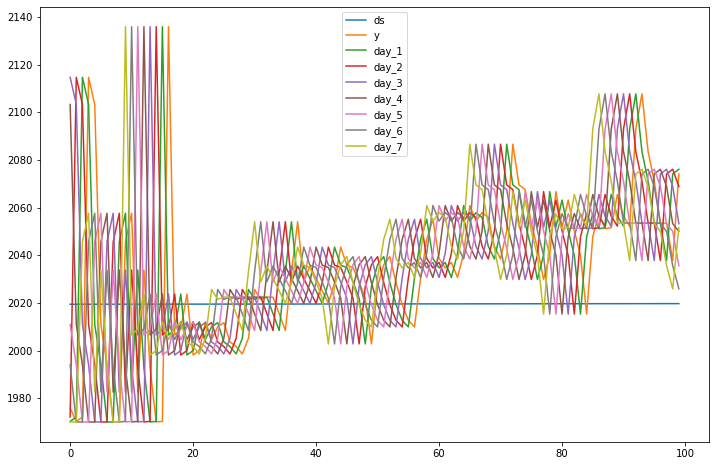

In [135]:
#df_d.set_index('ds')
df_d[:100].plot(figsize=(12,8))

In [136]:
df_d = df_d.dropna()

In [137]:
x1, x2, x3, x4,x5, x6, x7, y = df_d['day_1'], df_d['day_2'], df_d['day_3'], df_d['day_4'], df_d['day_5'], df_d['day_6'], df_d['day_7'], df_d['y']
x1, x2, x3, x4, x5, x6, x7, y = np.array(x1), np.array(x2), np.array(x3), np.array(x4), np.array(x5), np.array(x6), np.array(x7), np.array(y)
x1, x2, x3, x4, x5, x6, x7, y = x1.reshape(-1,1), x2.reshape(-1,1), x3.reshape(-1,1), x4.reshape(-1,1),x5.reshape(-1,1), x6.reshape(-1,1),x7.reshape(-1,1), y.reshape(-1,1)

split_percentage = 15
test_split = int(len(df_d)*(split_percentage/100))
x = np.concatenate((x1, x2, x3, x4,x5, x6, x7), axis=1)
X_train,X_test,y_train,y_test = x[:-test_split],x[-test_split:],y[:-test_split],y[-test_split:]

In [138]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(810, 7)
(142, 7)
(810, 1)
(142, 1)


## 6- Random Forest Regression

In [139]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)



<ipython-input-139-579391777d65>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor()

In [140]:
y_pred = rf_regressor.predict(X_test)

In [141]:
mse =  

R Sq. Score for Random Forest Regression : 0.5515497552681923


Compare the actual values agianst the test values

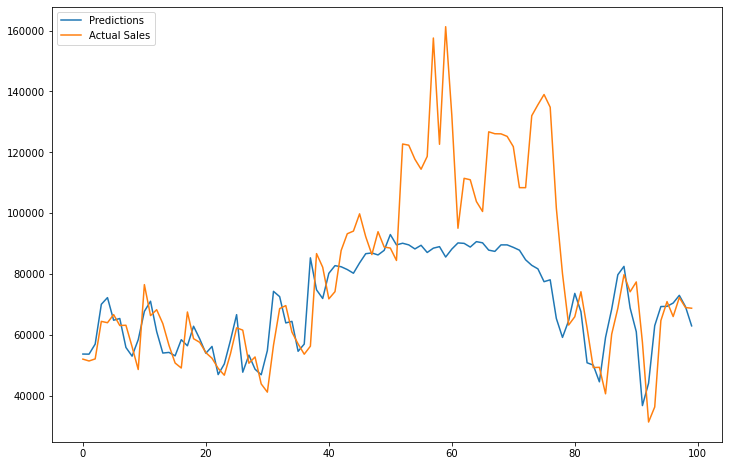

In [142]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(y_pred[-100:], label='Predictions')
plt.plot(y_test[-100:], label='Actual Sales')
plt.legend(loc="upper left")
plt.show()

### 7- Hyper parameter Tuning for RandomForestRegressor

In [143]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(0, 120, num = 20)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 72, 94, 116, 138, 161, 183, 205, 227, 250], 'max_features': ['auto', 'sqrt'], 'max_depth': [0, 6, 12, 18, 25, 31, 37, 44, 50, 56, 63, 69, 75, 82, 88, 94, 101, 107, 113, 120, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [144]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)

In [145]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [0, 6, 12, 18, 25, 31, 37,
                                                      44, 50, 56, 63, 69, 75,
                                                      82, 88, 94, 101, 107, 113,
                                                      120, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=0, verbose=2)

In [146]:
# Find the best parameters
rf_random.best_params_

{'n_estimators': 138,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 113,
 'bootstrap': True}

In [147]:
best_random = rf_random.best_estimator_

In [148]:
y_pred1 = best_random.predict(X_test)

In [149]:
print("R Sq. Score for Random Forest Regression :", best_random.score(X_test, y_test))
print('mse for Random Forest before tuning the parameters:', mean_squared_error(y_test, y_pred))

R Sq. Score for Random Forest Regression : 0.5981606507553612
mse for Random Forest before tuning the parameters: 343694768.7607165


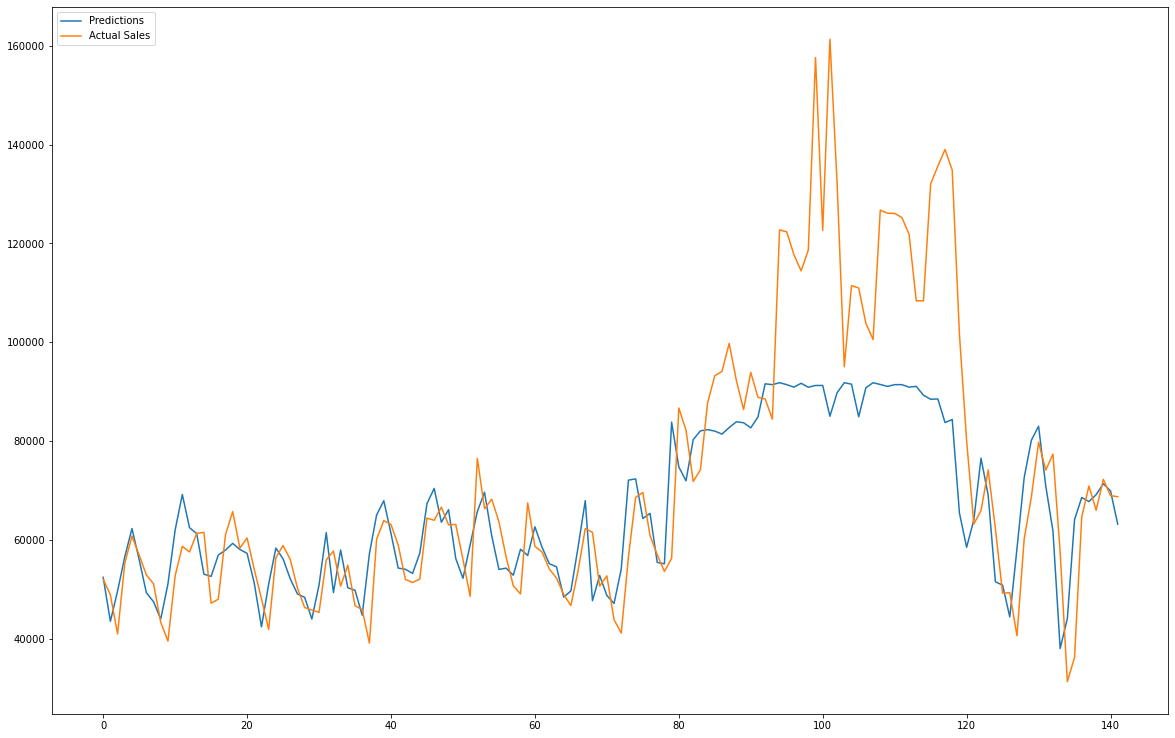

In [154]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,13)
plt.plot(y_pred1, label='Predictions')
plt.plot(y_test, label='Actual Sales')
plt.legend(loc="upper left")
plt.savefig('final.png')
plt.show()

In [151]:
mse=mean_squared_error(y_test, y_pred1)
mse

307971918.4905087

Comparing the results

In [152]:
 #Means Squared Error and RSME

mse=mean_squared_error(y_test, y_pred1)
print('MSE after tuning the parameters: ', mse)
print('MSE before tuning the parameters:', mean_squared_error(y_test, y_pred))


MSE after tuning the parameters:  307971918.4905087
MSE before tuning the parameters: 343694768.7607165
